utilisation de beautifulSoup pour scrapping

In [1]:
# pip install BeautifulSoup4
# https://towardsdatascience.com/a-practitioners-guide-to-natural-language-processing-part-i-processing-understanding-text-9f4abfd13e72

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline

Scrapping des urls , et recuperation du titre et de l article

In [3]:
seed_urls = [
            'https://inshorts.com/en/read/technology',
            'https://inshorts.com/en/read/sports',
            'https://inshorts.com/en/read/world'
            ]

def build_dataset(seed_urls):
    news_data = []
    for url in seed_urls:
        news_category = url.split('/')[-1]
        data = requests.get(url)
        soup = BeautifulSoup(data.content, 'html.parser')
        
        news_articles = [{'news_headline': headline.find('span', 
                                                         attrs={"itemprop": "headline"}).string,
                          'news_article': article.find('div', 
                                                       attrs={"itemprop": "articleBody"}).string,
                          'news_category': news_category}
                         
                            for headline, article in 
                             zip(soup.find_all('div', 
                                               class_=["news-card-title news-right-box"]),
                                 soup.find_all('div', 
                                               class_=["news-card-content news-right-box"]))
                        ]
        news_data.extend(news_articles)
        
    df =  pd.DataFrame(news_data)
    df = df[['news_headline', 'news_article', 'news_category']]
    return df


In [4]:
news_df = build_dataset(seed_urls) 
news_df

,news_headline,news_article,news_category
0,"Cogent, one of the world's largest internet service providers, shuts services in Russia","US-based Cogent Communications, an internet backbone provider that carries nearly 25% of global web traffic, is shutting off its services in Russia amid the Russia-Ukraine conflict. The company cited ""economic sanctions"" and ""the increasingly uncertain security situation"" for its decision. Cogent provides internet access and data transport offered over its fiber optic, IP data-only network.",technology
1,19-year-old who tracked Musk's jet to now track Russian billionaires' yachts,"Jack Sweeney, the 19-year-old student who tracks the world's richest person Elon Musk's private jet, has now created a Twitter account to track the yachts of Russian billionaires, including President Vladimir Putin. Sweeney had started tracking the aircraft of some of Russia's richest people at the end of February after they came under sanctions pressure following Russia's invasion of Ukraine.",technology
2,Zelenskyy invites world's richest man Elon Musk to visit Ukraine; shares video,"Ukraine's President Volodymyr Zelenskyy on a video call with Elon Musk invited the world's richest man to visit Ukraine. ""So, If you have time after the war, you are very welcome, I invite you,"" Zelenskyy told Musk. In a video clip shared by Zelenskyy on Instagram, Musk responded, ""That sound's good, I look forward to visiting once things are...""",technology
3,"Russian man smashes his iPad after Apple stops selling products in Russia, video viral","Footage shows a Russian man smashing his iPad after Apple decided to stop selling its products in Russia amid invasion of Ukraine. He uses a hammer to smash it, also getting his son to deliver a few blows. ""Here's our response to American sanctions! We don't fear you! We'll live without your nice 'pretty' things!"" the man said.",technology
4,"Netflix suspends its services, TikTok blocks new uploads in Russia","Netflix has announced that it is suspending its services in Russia after the country launched the invasion of Ukraine. Additionally, China's ByteDance-owned TikTok is blocking livestreaming and uploading of new content after Russia passed a law criminalising spreading of ""fake news"" about its army. Netflix earlier said it was temporarily stopping all future projects and acquisitions in Russia.",technology
...,...,...,...
70,German embassy denies Russian claim of fighting Nazism in Ukraine,"German embassy in South Africa has denied its Russian counterpart's claim that the latter is ""fighting Nazism in Ukraine"", saying, ""What Russia is doing in Ukraine is slaughtering innocent children, women and men for its own gain."" ""Sadly, we're kinda experts on Nazism,"" it added. Russian embassy had also thanked South Africans for their ""letters of solidarity"" amid Russia-Ukraine conflict.",world
71,4-yr-old child tests +ve for polio in Israel in 1st case since 1989,"A four-year-old child has tested positive for polio in Israel's Jerusalem in the country's first case since 1989, reported the Jerusalem Post. The country's Health Ministry said that the child hadn't been vaccinated against the virus as part of routine vaccinations in the country. It also added that the regional health administration has opened an epidemiological investigation into the matter.",world
72,Europe still has room for further sanctions against Russia: France,"French Finance Minister Bruno Le Maire on Monday said Europe and France still have room to implement further sanctions against Russia for invading Ukraine last month. ""Yes there are margins for manoeuvre. All options are on the table,"" Le Maire added. Till date, European Union (EU) has imposed three packages of sanctions including freezing assets of Russian central bank.",world
73,Philippines raises age of sexual consent from 12 to 16,"Philippines has raised age of sexual consent from 12 to 16, President Rodrigo Duterte's office said on Monday. Under

In [5]:
news_df.news_category.value_counts()

technology    25
sports        25
world         25
Name: news_category, dtype: int64

**Pre-traitement et nettoyage du texte**

utilisation de nltk et spacy

In [6]:
# python -m spacy download en_core_web_md
# nltk.download('stopwords')

In [7]:
# import spacy
# spacy.load('en_core_web_md')

In [8]:
import spacy
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
import re
from bs4 import BeautifulSoup
from contractions import CONTRACTION_MAP
import unicodedata
nlp = spacy.load('en_core_web_md', parse=True, tag=True, entity=True)
#nlp_vec = spacy.load('en_vecs', parse = True, tag=True, #entity=True)
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')

In [9]:
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text


def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text


def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text


print(remove_accented_chars('Sómě Áccěntěd těxt'))

print(remove_special_characters("Well this was fun! What do you think? 123#@!", remove_digits=True))

Some Accented text
Well this was fun What do you think 


In [10]:
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

expand_contractions("Y'all can't expand contractions I'd think")

'You all cannot expand contractions I would think'

In [68]:
def simple_stemmer(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

simple_stemmer("My system keeps crashing his crashed yesterday, ours crashes daily")

'my system keep crash hi crash yesterday, our crash daili'

In [12]:
def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

lemmatize_text("My system keeps crashing! his crashed yesterday, ours crashes daily")

'My system keep crash ! his crashed yesterday , ours crash daily'

In [13]:
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

remove_stopwords("The, and, if are stopwords, computer is not")


', , stopwords , computer not'

 ## Building a Text Normalizer

In [14]:
def normalize_corpus(corpus, html_stripping=True, contraction_expansion=True,
                     accented_char_removal=True, text_lower_case=True, 
                     text_lemmatization=True, special_char_removal=True, 
                     stopword_removal=True, remove_digits=True):
    
    normalized_corpus = []
    # normalize each document in the corpus
    for doc in corpus:
        # strip HTML
        if html_stripping:
            doc = strip_html_tags(doc)
        # remove accented characters
        if accented_char_removal:
            doc = remove_accented_chars(doc)
        # expand contractions    
        if contraction_expansion:
            doc = expand_contractions(doc)
        # lowercase the text    
        if text_lower_case:
            doc = doc.lower()
        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        # lemmatize text
        if text_lemmatization:
            doc = lemmatize_text(doc)
        # remove special characters and\or digits    
        if special_char_removal:
            # insert spaces between special characters to isolate them    
            special_char_pattern = re.compile(r'([{.(-)!}])')
            doc = special_char_pattern.sub(" \\1 ", doc)
            doc = remove_special_characters(doc, remove_digits=remove_digits)  
        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        # remove stopwords
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)
            
        normalized_corpus.append(doc)
        
    return normalized_corpus

In [15]:

# combining headline and article text
news_df['full_text'] = news_df["news_headline"].map(str)+ '. ' + news_df["news_article"]

# pre-process text and store the same
news_df['clean_text'] = normalize_corpus(news_df['full_text'])
norm_corpus = list(news_df['clean_text'])

# show a sample news article
news_df.iloc[0][['full_text', 'clean_text']].to_dict()

{'full_text': 'Cogent, one of the world\'s largest internet service providers, shuts services in Russia. US-based Cogent Communications, an internet backbone provider that carries nearly 25% of global web traffic, is shutting off its services in Russia amid the Russia-Ukraine conflict. The company cited "economic sanctions" and "the increasingly uncertain security situation" for its decision. Cogent provides internet access and data transport offered over its fiber optic, IP data-only network.',
 'clean_text': 'cogent one world large internet service provider shut service russia us base cogent communication internet backbone provider carry nearly global web traffic shut service russia amid russia ukraine conflict company cite economic sanction increasingly uncertain security situation decision cogent provide internet access datum transport offer fiber optic ip data network'}

In [16]:
news_df.to_csv('news.csv', index=False, encoding='utf-8')

Knowledge about the structure and syntax of language is helpful in many areas like text processing, annotation, and parsing for further operations such as text classification or summarization. Typical parsing techniques for understanding text syntax are mentioned below.
- Parts of Speech (POS) Tagging
- Shallow Parsing or Chunking
- Constituency Parsing
- Dependency Parsing

In [17]:
news_df[['full_text']].head()

,full_text
0,"Cogent, one of the world's largest internet service providers, shuts services in Russia. US-based Cogent Communications, an internet backbone provider that carries nearly 25% of global web traffic, is shutting off its services in Russia amid the Russia-Ukraine conflict. The company cited ""economic sanctions"" and ""the increasingly uncertain security situation"" for its decision. Cogent provides internet access and data transport offered over its fiber optic, IP data-only network."
1,"19-year-old who tracked Musk's jet to now track Russian billionaires' yachts. Jack Sweeney, the 19-year-old student who tracks the world's richest person Elon Musk's private jet, has now created a Twitter account to track the yachts of Russian billionaires, including President Vladimir Putin. Sweeney had started tracking the aircraft of some of Russia's richest people at the end of February after they came under sanctions pressure following Russia's invasion of Ukraine."
2,"Zelenskyy invites world's richest man Elon Musk to visit Ukraine; shares video. Ukraine's President Volodymyr Zelenskyy on a video call with Elon Musk invited the world's richest man to visit Ukraine. ""So, If you have time after the war, you are very welcome, I invite you,"" Zelenskyy told Musk. In a video clip shared by Zelenskyy on Instagram, Musk responded, ""That sound's good, I look forward to visiting once things are..."""
3,"Russian man smashes his iPad after Apple stops selling products in Russia, video viral. Footage shows a Russian man smashing his iPad after Apple decided to stop selling its products in Russia amid invasion of Ukraine. He uses a hammer to smash it, also getting his son to deliver a few blows. ""Here's our response to American sanctions! We don't fear you! We'll live without your nice 'pretty' things!"" the man said."
4,"Netflix suspends its services, TikTok blocks new uploads in Russia. Netflix has announced that it is suspending its services in Russia after the country launched the invasion of Ukraine. Additionally, China's ByteDance-owned TikTok is blocking livestreaming and uploading of new content after Russia passed a law criminalising spreading of ""fake news"" about its army. Netflix earlier said it was temporarily stopping all future projects and acquisitions in Russia."


In [18]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ismail/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [114]:
# create a basic pre-processed corpus, don't lowercase to get POS context
corpus = normalize_corpus(news_df['full_text'], text_lower_case=False, 
                          text_lemmatization=False, special_char_removal=False)

# demo for POS tagging for sample news headline
sentence = str(news_df.iloc[1].news_headline)
sentence_nlp = nlp(sentence)

sentence2 = str(news_df.iloc[0].news_headline)
sentence_nlp2 = nlp(sentence2)

# POS tagging with Spacy 
print('POS tagging with Spacy ')
spacy_pos_tagged = [(word, word.tag_, word.pos_) for word in sentence_nlp]
display(pd.DataFrame(spacy_pos_tagged, columns=['Word', 'POS tag', 'Tag type']))

print('POS tagging with nltk')
# POS tagging with nltk
nltk_pos_tagged = nltk.pos_tag(sentence.split())
nltk_pos_tagged2 = nltk.pos_tag(sentence2.split())
display(pd.DataFrame(nltk_pos_tagged, columns=['Word', 'POS tag']))

POS tagging with Spacy 


,Word,POS tag,Tag type
0,19-year,CD,NUM
1,-,HYPH,PUNCT
2,old,JJ,ADJ
3,who,WP,PRON
4,tracked,VBD,VERB
...,...,...,...
10,track,VB,VERB
11,Russian,JJ,ADJ
12,billionaires,NNS,NOUN
13,',POS,PART


POS tagging with nltk


,Word,POS tag
0,19-year-old,JJ
1,who,WP
2,tracked,VBD
3,Musk's,NNP
4,jet,NN
...,...,...
6,now,RB
7,track,VB
8,Russian,JJ
9,billionaires',NN


In [107]:
sentence3 = str('The brown fox is quick and he is jumping over the lazy dog')
sentence_nlp3 = nlp(sentence3)
sentence3
nltk_pos_tagged3 = nltk.pos_tag(sentence3.split())
display(pd.DataFrame(nltk_pos_tagged3, columns=['Word', 'POS tag']))

,Word,POS tag
0,The,DT
1,brown,JJ
2,fox,NN
3,is,VBZ
4,quick,JJ
...,...,...
8,jumping,VBG
9,over,IN
10,the,DT
11,lazy,JJ


## segmentation

L'analyse superficielle, également connue sous le nom d'analyse légère ou de segmentation, est une technique populaire de traitement du langage naturel consistant à analyser la structure d'une phrase pour la décomposer en ses plus petits constituants (qui sont des jetons tels que des mots) et les regrouper en phrases de niveau supérieur. . Cela inclut les balises POS ainsi que les expressions d'une phrase.

<img src='https://miro.medium.com/max/1176/1*dq-BbcMMkLmDDcSCdzQIzA.png'></img>


- **Phrase nominale (NP)**: Ce sont des phrases où un nom agit comme mot principal. Les phrases nominales agissent comme sujet ou objet d'un verbe.
- **Phrase verbale (VP)** : ces phrases sont des unités lexicales qui ont un verbe agissant comme mot principal. Habituellement, il existe deux formes de phrases verbales. Une forme a les composants verbaux ainsi que d'autres entités telles que des noms, des adjectifs ou des adverbes comme parties de l'objet.
- **Phrase adjective (ADJP)**: Ce sont des phrases avec un adjectif comme mot principal. Leur rôle principal est de décrire ou de qualifier les noms et les pronoms dans une phrase, et ils seront placés soit avant, soit après le nom ou le pronom.
- **Phrase adverbiale (ADVP)**: Ces phrases agissent comme des adverbes puisque l'adverbe agit comme le mot principal dans la phrase. Les expressions adverbiales sont utilisées comme modificateurs pour les noms, les verbes ou les adverbes eux-mêmes en fournissant des détails supplémentaires qui les décrivent ou les qualifient.
- **Phrase prépositionnelle (PP)**: Ces phrases contiennent généralement une préposition comme mot principal et d'autres composants lexicaux comme les noms, les pronoms, etc. Ceux-ci agissent comme un adjectif ou un adverbe décrivant d'autres mots ou expressions.

Nous tirerons parti du conll2000corpus pour entraîner notre modèle d'analyseur superficiel. 
Ce corpus est disponible nltk avec des annotations de blocs et 
nous utiliserons environ 10 000 enregistrements pour former notre modèle. 



In [20]:
nltk.download('conll2000')

[nltk_data] Downloading package conll2000 to /home/ismail/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!


True

In [21]:
from nltk.corpus import conll2000

data = conll2000.chunked_sents()
train_data = data[:10900]
test_data = data[10900:] 

print(len(train_data), len(test_data))
print(train_data[1]) 

10900 48
(S
  Chancellor/NNP
  (PP of/IN)
  (NP the/DT Exchequer/NNP)
  (NP Nigel/NNP Lawson/NNP)
  (NP 's/POS restated/VBN commitment/NN)
  (PP to/TO)
  (NP a/DT firm/NN monetary/JJ policy/NN)
  (VP has/VBZ helped/VBN to/TO prevent/VB)
  (NP a/DT freefall/NN)
  (PP in/IN)
  (NP sterling/NN)
  (PP over/IN)
  (NP the/DT past/JJ week/NN)
  ./.)


À partir de la sortie précédente, vous pouvez voir que nos points de données sont des phrases qui sont déjà annotées avec des phrases et des métadonnées de balises POS qui seront utiles pour former notre modèle d'analyseur superficiel. Nous tirerons parti de deux fonctions utilitaires de segmentation, tree2conlltags , pour obtenir des triplets de mots, de balises et de balises de segment pour chaque jeton, et conlltags2tree pour générer un arbre d'analyse à partir de ces triplets de jetons. Nous utiliserons ces fonctions pour entraîner notre parseur.

In [38]:
from nltk.chunk.util import tree2conlltags, conlltags2tree

wtc = tree2conlltags(train_data[0])
wtc

[('Confidence', 'NN', 'B-NP'),
 ('in', 'IN', 'B-PP'),
 ('the', 'DT', 'B-NP'),
 ('pound', 'NN', 'I-NP'),
 ('is', 'VBZ', 'B-VP'),
 ('widely', 'RB', 'I-VP'),
 ('expected', 'VBN', 'I-VP'),
 ('to', 'TO', 'I-VP'),
 ('take', 'VB', 'I-VP'),
 ('another', 'DT', 'B-NP'),
 ('sharp', 'JJ', 'I-NP'),
 ('dive', 'NN', 'I-NP'),
 ('if', 'IN', 'O'),
 ('trade', 'NN', 'B-NP'),
 ('figures', 'NNS', 'I-NP'),
 ('for', 'IN', 'B-PP'),
 ('September', 'NNP', 'B-NP'),
 (',', ',', 'O'),
 ('due', 'JJ', 'O'),
 ('for', 'IN', 'B-PP'),
 ('release', 'NN', 'B-NP'),
 ('tomorrow', 'NN', 'B-NP'),
 (',', ',', 'O'),
 ('fail', 'VB', 'B-VP'),
 ('to', 'TO', 'I-VP'),
 ('show', 'VB', 'I-VP'),
 ('a', 'DT', 'B-NP'),
 ('substantial', 'JJ', 'I-NP'),
 ('improvement', 'NN', 'I-NP'),
 ('from', 'IN', 'B-PP'),
 ('July', 'NNP', 'B-NP'),
 ('and', 'CC', 'I-NP'),
 ('August', 'NNP', 'I-NP'),
 ("'s", 'POS', 'B-NP'),
 ('near-record', 'JJ', 'I-NP'),
 ('deficits', 'NNS', 'I-NP'),
 ('.', '.', 'O')]

Les balises de bloc utilisent le format IOB. Cette notation représente l'intérieur, l'extérieur et le début. 

- Le préfixe B- avant une balise indique qu'il s'agit du début d'un bloc
- le préfixe I- indique qu'il se trouve à l'intérieur d'un bloc. 
- La balise O indique que le jeton n'appartient à aucun bloc. 

La balise B est toujours utilisée lorsqu'il y a des balises suivantes du même type qui la suivent sans la présence de balises O entre elles.

Nous allons maintenant définir une fonction conll_tag_ chunks()pour extraire les balises POS et chunk des phrases avec des annotations chunked et une fonction appelée combined_taggers()pour former plusieurs taggeurs avec des taggeurs backoff (par exemple les taggeurs unigram et bigram)

Nous allons maintenant définir une classe <code>NGramTagChunker</code> qui acceptera des phrases balisées comme entrée de formation, obtiendra leurs triplets WTC (mot, balise POS, balise Chunk) et formera avec a comme marqueur de backoff. Nous définirons également une fonction pour effectuer une analyse superficielle sur les nouvelles phrases <code>BigramTaggerUnigramTagger parse()</code>

Les classes <code>UnigramTagger, BigramTaggeret TrigramTaggersont</code>  héritent de la classe de base <code>NGramTagger</code>, qui elle-même hérite de la <code>ContextTaggerclasse</code> , qui hérite de la <code>SequentialBackoffTaggerclasse</code> .

Nous utiliserons cette classe pour nous entraîner sur le conll2000chunked 
train_data et évaluer les performances du modèle sur le test_data

In [23]:
from nltk.tag import UnigramTagger, BigramTagger
from nltk.chunk import ChunkParserI


def conll_tag_chunks(chunk_sents):
    tagged_sents = [tree2conlltags(tree) for tree in chunk_sents]
    return [[(t, c) for (w, t, c) in sent] for sent in tagged_sents]


def combined_tagger(train_data, taggers, backoff=None):
    for tagger in taggers:
        backoff = tagger(train_data, backoff=backoff)
    return backoff 

# define the chunker class
class NGramTagChunker(ChunkParserI):
    
  def __init__(self, train_sentences, 
               tagger_classes=[UnigramTagger, BigramTagger]):
    train_sent_tags = conll_tag_chunks(train_sentences)
    self.chunk_tagger = combined_tagger(train_sent_tags, tagger_classes)

  def parse(self, tagged_sentence):
    if not tagged_sentence: 
        return None
    pos_tags = [tag for word, tag in tagged_sentence]
    chunk_pos_tags = self.chunk_tagger.tag(pos_tags)
    chunk_tags = [chunk_tag for (pos_tag, chunk_tag) in chunk_pos_tags]
    wpc_tags = [(word, pos_tag, chunk_tag) for ((word, pos_tag), chunk_tag)
                     in zip(tagged_sentence, chunk_tags)]
    return conlltags2tree(wpc_tags)
  
# train chunker model  
ntc = NGramTagChunker(train_data)

# evaluate chunker model performance
print(ntc.evaluate(test_data))

ChunkParse score:
    IOB Accuracy:  90.0%%
    Precision:     82.1%%
    Recall:        86.3%%
    F-Measure:     84.1%%


/tmp/ipykernel_39962/460067074.py:37: DeprecationWarning: 
  Function evaluate() has been deprecated.  Use accuracy(gold)
  instead.
  print(ntc.evaluate(test_data))


Tirons maintenant parti de ce modèle pour analyser et découper en profondeur notre exemple de titre d'article de presse que nous avons utilisé plus tôt

In [39]:
nltk_pos_tagged

[('19-year-old', 'JJ'),
 ('who', 'WP'),
 ('tracked', 'VBD'),
 ("Musk's", 'NNP'),
 ('jet', 'NN'),
 ('to', 'TO'),
 ('now', 'RB'),
 ('track', 'VB'),
 ('Russian', 'JJ'),
 ("billionaires'", 'NN'),
 ('yachts', 'NNS')]

In [24]:
chunk_tree = ntc.parse(nltk_pos_tagged) 
print(chunk_tree)

(S
  (NP 19-year-old/JJ)
  (NP who/WP)
  (VP tracked/VBD)
  (NP Musk's/NNP jet/NN)
  (VP to/TO now/RB track/VB)
  (NP Russian/JJ billionaires'/NN yachts/NNS))


In [42]:
chunk_tree2 = ntc.parse(nltk_pos_tagged2) 
print(chunk_tree2)

(S
  (NP Cogent,/NNP one/CD)
  (PP of/IN)
  (NP
    the/DT
    world's/NN
    largest/JJS
    internet/NN
    service/NN
    providers,/NN
    shuts/NNS
    services/NNS)
  (PP in/IN)
  (NP Russia/NNP))


In [87]:
chunk_tree3 = ntc.parse(nltk_pos_tagged3) 
print(chunk_tree3)

(S
  (NP The/DT brown/JJ fox/NN)
  (VP is/VBZ)
  (NP quick/JJ)
  and/CC
  (NP he/PRP)
  (VP is/VBZ jumping/VBG)
  (PP over/IN)
  (NP the/DT lazy/JJ dog/NN))


Ainsi, vous pouvez voir qu'il a identifié des phrases nominales (NP) et une phrase verbale (VP) dans l'article de presse. Les balises POS de chaque mot sont également visibles. Nous pouvons également visualiser cela sous la forme d'un arbre comme suit.

In [30]:
pip install svgling

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 66 kB 935 kB/s            
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


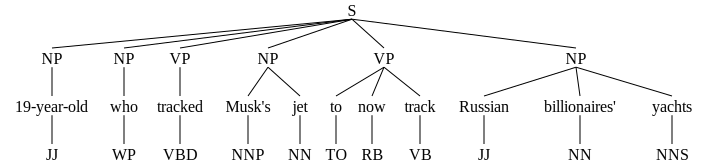

In [31]:
display(chunk_tree)

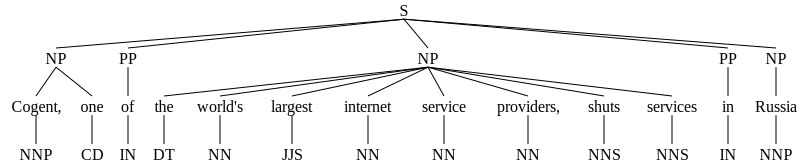

In [43]:
display(chunk_tree2)

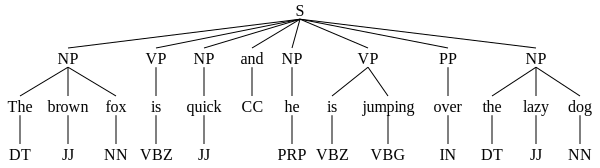

In [88]:
display(chunk_tree3)

## Structure de phrase

Les règles de structure de phrase forment le noyau des grammaires de circonscription, car elles parlent de la syntaxe et des règles qui régissent la hiérarchie et l'ordre des différents constituants dans les phrases. Ces règles répondent à deux choses principalement.

- Ils déterminent quels mots sont utilisés pour construire les phrases ou les constituants.
- Ils déterminent comment nous devons ordonner ces constituants ensemble.

<img src="https://miro.medium.com/max/1212/1*JT4n7Xeo4A5hrR0Q01Wk4A.png"></img>

Nous utiliserons nltket StanfordParser ici pour générer des arbres d'analyse.

In [62]:
# set java path
import os
from nltk.parse.stanford import StanfordParser

java_path = r'/usr/bin/java'
os.environ['JAVAHOME'] = java_path

scp = StanfordParser(path_to_jar='stanford-parser-full-2015-04-20/stanford-parser.jar',
                     path_to_models_jar='standfordParse/stanford-corenlp-4.2.0-models-english.jar')
                   
result = list(scp.raw_parse(sentence))
print(result[0])

/tmp/ipykernel_39962/1681516210.py:7: DeprecationWarning: The StanfordParser will be deprecated
Please use nltk.parse.corenlp.CoreNLPParser instead.
  scp = StanfordParser(path_to_jar='stanford-parser-full-2015-04-20/stanford-parser.jar',


(ROOT
  (ADJP
    (ADJP (JJ 19-year-old))
    (SBAR
      (WHNP (WP who))
      (S
        (VP
          (VBD tracked)
          (NP
            (NP (NNP Musk) (POS 's))
            (NN jet)
            (S
              (VP
                (TO to)
                (VP
                  (ADVP (RB now))
                  (VB track)
                  (NP
                    (NP (JJ Russian) (NNS billionaires) (POS '))
                    (NNS yachts)))))))))))


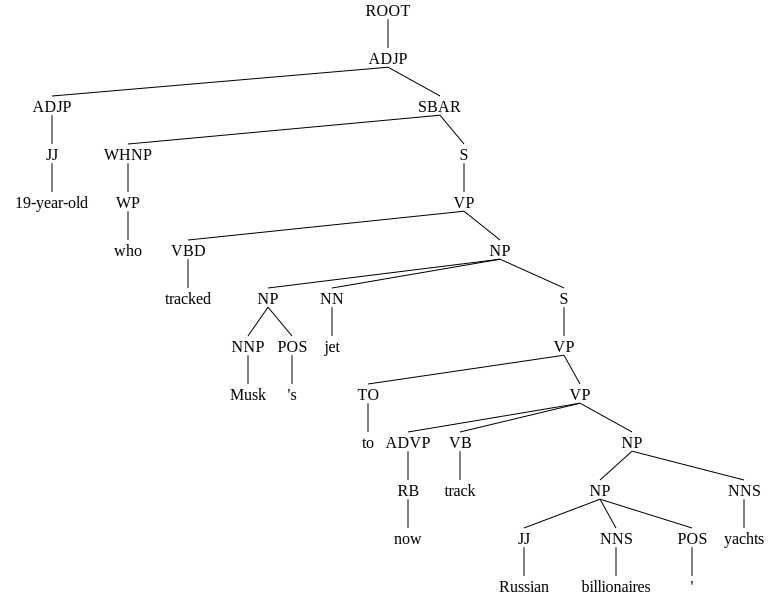

In [67]:
display(result[0])

In [66]:
result2 = list(scp.raw_parse(sentence2))
print(result2[0])

(ROOT
  (S
    (NP
      (NP (NNP Cogent))
      (, ,)
      (NP
        (NP (CD one))
        (PP
          (IN of)
          (NP
            (NP (DT the) (NN world) (POS 's))
            (JJS largest)
            (NN internet)
            (NN service)
            (NNS providers))))
      (, ,))
    (VP
      (VBZ shuts)
      (NP (NP (NNS services)) (PP (IN in) (NP (NNP Russia)))))))


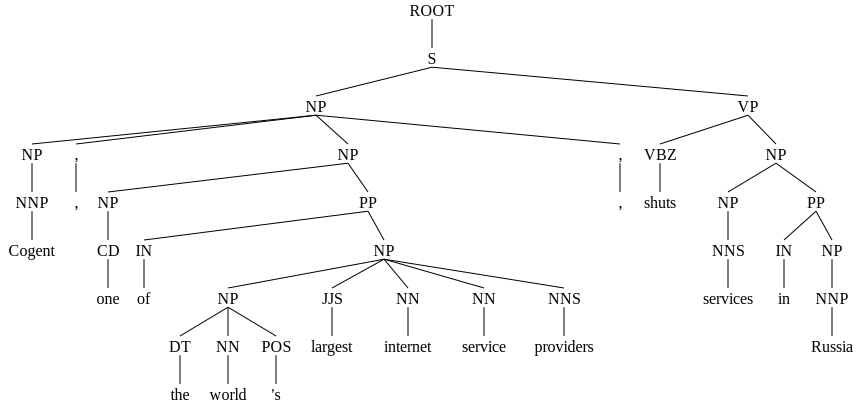

In [69]:
display(result2[0])

In [89]:
result3 = list(scp.raw_parse(sentence3))
print(result3[0])

(ROOT
  (NP
    (S
      (S
        (NP (DT The) (JJ brown) (NN fox))
        (VP (VBZ is) (ADJP (JJ quick))))
      (CC and)
      (S
        (NP (PRP he))
        (VP
          (VBZ is)
          (VP
            (VBG jumping)
            (PP (IN over) (NP (DT the) (JJ lazy) (NN dog)))))))))


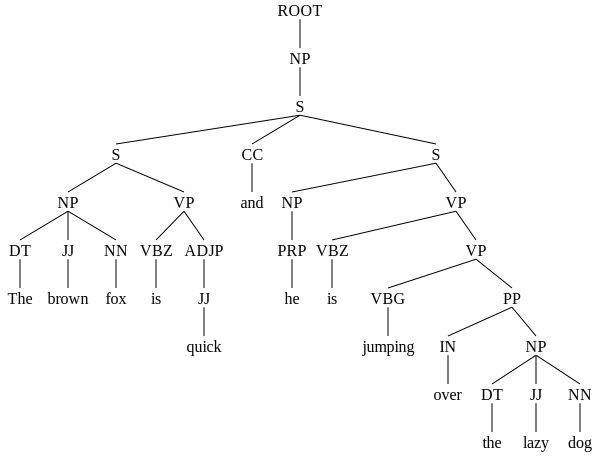

In [90]:
display(result3[0])

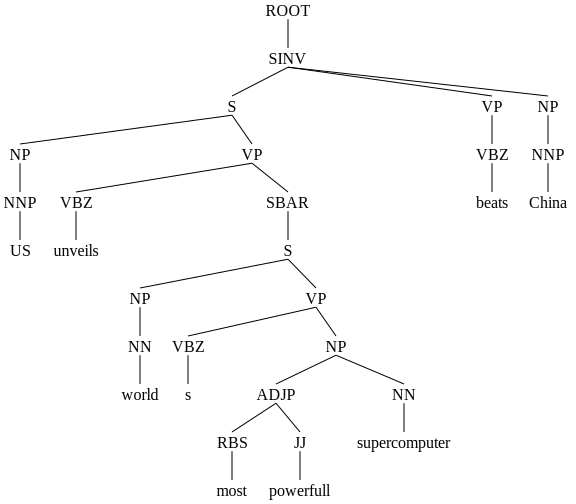

In [95]:
sentence3 = str('US unveils world s most powerfull supercomputer beats China')
sentence3
nltk_pos_tagged3 = nltk.pos_tag(sentence3.split())
result3 = list(scp.raw_parse(sentence3))
display(result3[0])

 SINV , il représente une phrase déclarative inversée , c'est-à-dire une phrase dans laquelle le sujet suit le verbe tendu ou modal

## Analyse des dépendances

Dans l'analyse des dépendances, nous essayons d'utiliser des grammaires basées sur les dépendances pour analyser et déduire à la fois les dépendances structurelles et sémantiques et les relations entre les jetons dans une phrase. Le principe de base derrière une grammaire de dépendance est que dans n'importe quelle phrase de la langue, tous les mots sauf un, ont une relation ou une dépendance avec d'autres mots de la phrase. Le mot qui n'a pas de dépendance s'appelle la racine de la phrase. Le verbe est pris comme racine de la phrase dans la plupart des cas. Tous les autres mots sont liés directement ou indirectement au verbe racine à l'aide de liens , qui sont les dépendances.

In [96]:
dependency_pattern = '{left}<---{word}[{w_type}]--->{right}\n--------'
for token in sentence_nlp:
    print(dependency_pattern.format(word=token.orth_, 
                                  w_type=token.dep_,
                                  left=[t.orth_ 
                                            for t 
                                            in token.lefts],
                                  right=[t.orth_ 
                                             for t 
                                             in token.rights]))

[]<---19-year[nummod]--->[]
--------
[]<----[punct]--->[]
--------
['19-year', '-']<---old[nsubj]--->['tracked']
--------
[]<---who[nsubj]--->[]
--------
['who']<---tracked[relcl]--->['jet']
--------
[]<---Musk[poss]--->["'s"]
--------
[]<---'s[case]--->[]
--------
['Musk']<---jet[dobj]--->[]
--------
[]<---to[aux]--->[]
--------
[]<---now[advmod]--->[]
--------
['old', 'to', 'now']<---track[ROOT]--->['yachts']
--------
[]<---Russian[amod]--->[]
--------
['Russian']<---billionaires[poss]--->["'"]
--------
[]<---'[case]--->[]
--------
['billionaires']<---yachts[dobj]--->[]
--------


In [109]:
from spacy import displacy

displacy.render(sentence_nlp, jupyter=True, 
                options={'distance': 110,
                         'arrow_stroke': 2,
                         'arrow_width': 8})

In [108]:
dependency_pattern = '{left}<---{word}[{w_type}]--->{right}\n--------'
for token in sentence_nlp3:
    print(dependency_pattern.format(word=token.orth_, 
                                  w_type=token.dep_,
                                  left=[t.orth_ 
                                            for t 
                                            in token.lefts],
                                  right=[t.orth_ 
                                             for t 
                                             in token.rights]))

[]<---The[det]--->[]
--------
[]<---brown[amod]--->[]
--------
['The', 'brown']<---fox[nsubj]--->[]
--------
['fox']<---is[ROOT]--->['quick', 'and', 'jumping']
--------
[]<---quick[acomp]--->[]
--------
[]<---and[cc]--->[]
--------
[]<---he[nsubj]--->[]
--------
[]<---is[aux]--->[]
--------
['he', 'is']<---jumping[conj]--->['over']
--------
[]<---over[prep]--->['dog']
--------
[]<---the[det]--->[]
--------
[]<---lazy[amod]--->[]
--------
['the', 'lazy']<---dog[pobj]--->[]
--------


In [118]:
from spacy import displacy
sentence3 = str('The brown fox is quick and he is jumping over the lazy dog')
sentence_nlp3 = nlp(sentence3)

displacy.render(sentence_nlp3, jupyter=True, 
                options={'distance': 110,
                         'arrow_stroke': 2,
                         'arrow_width': 8})

In [115]:
from spacy import displacy

displacy.render(sentence_nlp2, jupyter=True, 
                options={'distance': 110,
                         'arrow_stroke': 2,
                         'arrow_width': 8})

## Reconnaissance d'entité nommée

Dans tout document texte, il existe des termes particuliers qui représentent des entités spécifiques qui sont plus informatifs et ont un contexte unique. Ces entités sont connues sous le nom d'entités nommées , qui font plus spécifiquement référence à des termes qui représentent des objets du monde réel tels que des personnes, des lieux, des organisations, etc., qui sont souvent désignés par des noms propres. Une approche naïve pourrait être de les trouver en regardant les phrases nominales dans les documents textuels. La reconnaissance d'entités nommées (NER), également connue sous le nom de segmentation/extraction d'entités, est une technique populaire utilisée dans l'extraction d'informations pour identifier et segmenter les entités nommées et les classer ou les catégoriser dans diverses classes prédéfinies.

SpaCy possède d'excellentes capacités de reconnaissance d'entités nommées. Essayons de l'utiliser sur l'un de nos exemples d'articles de presse.

In [124]:
news_df.iloc[1].full_text

"19-year-old who tracked Musk's jet to now track Russian billionaires' yachts. Jack Sweeney, the 19-year-old student who tracks the world's richest person Elon Musk's private jet, has now created a Twitter account to track the yachts of Russian billionaires, including President Vladimir Putin. Sweeney had started tracking the aircraft of some of Russia's richest people at the end of February after they came under sanctions pressure following Russia's invasion of Ukraine."

In [121]:

sentence = str(news_df.iloc[1].full_text)
sentence_nlp = nlp(sentence)

# print named entities in article
print([(word, word.ent_type_) for word in sentence_nlp if word.ent_type_])

# visualize named entities
displacy.render(sentence_nlp, style='ent', jupyter=True)

[(19-year, 'DATE'), (-, 'DATE'), (old, 'DATE'), (Musk, 'ORG'), (Russian, 'NORP'), (Jack, 'PERSON'), (Sweeney, 'PERSON'), (19-year, 'DATE'), (-, 'DATE'), (old, 'DATE'), (Elon, 'ORG'), (Musk, 'ORG'), ('s, 'ORG'), (Twitter, 'ORG'), (Russian, 'NORP'), (Vladimir, 'PERSON'), (Putin, 'PERSON'), (Sweeney, 'PERSON'), (Russia, 'GPE'), (the, 'DATE'), (end, 'DATE'), (of, 'DATE'), (February, 'DATE'), (Russia, 'GPE'), (Ukraine, 'GPE')]


In [127]:
named_entities = []
for sentence in corpus:
    temp_entity_name = ''
    temp_named_entity = None
    sentence = nlp(sentence)
    for word in sentence:
        term = word.text 
        tag = word.ent_type_
        if tag:
            temp_entity_name = ' '.join([temp_entity_name, term]).strip()
            temp_named_entity = (temp_entity_name, tag)
        else:
            if temp_named_entity:
                named_entities.append(temp_named_entity)
                temp_entity_name = ''
                temp_named_entity = None

entity_frame = pd.DataFrame(named_entities, 
                            columns=['Entity Name', 'Entity Type'])

Découvrons maintenant les entités nommées les plus fréquentes dans notre corpus d'actualités ! Pour cela, nous allons créer une trame de données de toutes les entités nommées et de leurs types

<img src='https://miro.medium.com/max/828/1*WX93S6ZIJH2zZjnZrQYFrQ.png'></img>

In [130]:
pd.set_option('display.max_columns', None)
# get the top named entities
top_entities = (entity_frame.groupby(by=['Entity Name', 'Entity Type'])
                           .size()
                           .sort_values(ascending=False)
                           .reset_index().rename(columns={0 : 'Frequency'}))
top_entities.T.iloc[:,:30]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
Entity Name,Ukraine,Russia,Russian,India,Ukrainian,US,Monday,first,Netflix,Zelenskyy,New Zealand,Ukraines,Indian,Ukrainians,China,Warnes,Ashwin,Volodymyr Zelenskyy,three,Kyiv,2022,Russians,Gautam Gambhir,Virat Kohli,Gambhir,Vladimir Putin,German,American,TikTok,Musk
Entity Type,GPE,GPE,NORP,GPE,NORP,GPE,DATE,ORDINAL,ORG,PERSON,GPE,ORG,NORP,NORP,GPE,PERSON,PERSON,PERSON,CARDINAL,GPE,DATE,NORP,PERSON,PERSON,PERSON,PERSON,NORP,NORP,ORG,ORG
Frequency,49,44,31,14,9,9,9,8,8,8,7,7,7,6,6,5,5,5,5,5,4,4,4,4,4,4,4,4,4,4


In [131]:
# get the top named entity types
top_entities = (entity_frame.groupby(by=['Entity Type'])
                           .size()
                           .sort_values(ascending=False)
                           .reset_index().rename(columns={0 : 'Frequency'}))
top_entities.T.iloc[:,:30]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
Entity Type,GPE,PERSON,ORG,NORP,DATE,CARDINAL,ORDINAL,TIME,LOC,PRODUCT,MONEY,FAC,EVENT,QUANTITY,LAW,PERCENT,WORK_OF_ART
Frequency,195,192,129,93,72,39,17,10,8,8,7,5,3,2,1,1,1


Nous pouvons voir que les personnes, les lieux et les organisations sont les entités les plus mentionnées, mais il est intéressant de noter que nous avons également de nombreuses autres entités.

Un autre joli tagger NER est StanfordNERTaggerdisponible depuis l' nltkinterface.

In [ ]:

from nltk.tag import StanfordNERTagger
import os



# initialize NER tagger
sn = StanfordNERTagger('stanford-ner-2015-04-20/classifiers/english.all.3class.distsim.crf.ser.gz',
                       path_to_jar='stanford-ner-2015-04-20/stanford-ner.jar')

# tag named entities
ner_tagged_sentences = [sn.tag(sent.split()) for sent in corpus]

# extract all named entities
named_entities = []
for sentence in ner_tagged_sentences:
    temp_entity_name = ''
    temp_named_entity = None
    for term, tag in sentence:
        if tag != 'O':
            temp_entity_name = ' '.join([temp_entity_name, term]).strip()
            temp_named_entity = (temp_entity_name, tag)
        else:
            if temp_named_entity:
                named_entities.append(temp_named_entity)
                temp_entity_name = ''
                temp_named_entity = None

#named_entities = list(set(named_entities))
entity_frame = pd.DataFrame(named_entities, 
                            columns=['Entity Name', 'Entity Type'])
                            

In [134]:
# view top entities and types
top_entities = (entity_frame.groupby(by=['Entity Name', 'Entity Type'])
                           .size()
                           .sort_values(ascending=False)
                           .reset_index().rename(columns={0 : 'Frequency'}))
top_entities.head(15)

,Entity Name,Entity Type,Frequency
0,Russia,LOCATION,37
1,Ukraine,LOCATION,31
2,India,LOCATION,15
3,Netflix,ORGANIZATION,8
4,US,LOCATION,7
...,...,...,...
10,Volodymyr Zelenskyy,PERSON,5
11,IPL,ORGANIZATION,5
12,Virat Kohli,PERSON,4
13,Google,ORGANIZATION,4


In [135]:
# view top entity types
top_entities = (entity_frame.groupby(by=['Entity Type'])
                           .size()
                           .sort_values(ascending=False)
                           .reset_index().rename(columns={0 : 'Frequency'}))
top_entities.head()

,Entity Type,Frequency
0,PERSON,171
1,LOCATION,163
2,ORGANIZATION,86


**Stanford’s Named Entity Recognizer** est basé sur une mise en œuvre de modèles de séquence de champ aléatoire conditionnel (CRF) à chaîne linéaire. Malheureusement, ce modèle n'est formé que sur des instances detypes PERSON , ORGANIZATION et LOCATION . Le code suivant peut être utilisé comme un flux de travail standard qui nous aide à extraire les entités nommées à l'aide de ce tagger et à afficher les principales entités nommées et leurs types (l'extraction diffère légèrement despacy).

# Analyse des emotions et sentiments

- AFINN Lexicon

In [137]:
# pip install afinn

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 52 kB 667 kB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for afinn: filename=afinn-0.1-py3-none-any.whl size=53449 sha256=40c1e23943785c6da88a43bdcf5cf82b0474190e56b1a8c969acebda48c2ad14
  Stored in directory: /home/ismail/.cache/pip/wheels/f6/6f/c3/b305c5107a17618f2938a067d5ffcbb556909d82398762089e
Successfully built afinn
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


Le lexique AFINN est peut-être l'un des lexiques les plus simples et les plus populaires qui peuvent être largement utilisés pour l'analyse des sentiments. Développé et organisé par Finn Årup Nielsen, vous pouvez trouver plus de détails sur ce lexique dans l'article, "A new ANEW: évaluation of a word list for sentiment analysis in microblogs", actes de l'ESWC 2011 Workshop. La version actuelle du lexique est AFINN-en-165. txt et il contient plus de 3 300 mots avec un score de polarité associé à chaque mot. Vous pouvez trouver ce lexique dans le référentiel <a target='_blanc' href='https://github.com/fnielsen/afinn/blob/master/afinn/data/'> GitHub officiel</a> de l'auteur avec les versions précédentes de celui-ci, y compris AFINN-111 . L'auteur a également créé une belle bibliothèque wrapper en

In [139]:
# initialize afinn sentiment analyzer
from afinn import Afinn
af = Afinn()

# compute sentiment scores (polarity) and labels
sentiment_scores = [af.score(article) for article in corpus]
sentiment_category = ['positive' if score > 0 
                          else 'negative' if score < 0 
                              else 'neutral' 
                                  for score in sentiment_scores]
    
    
# sentiment statistics per news category
df = pd.DataFrame([list(news_df['news_category']), sentiment_scores, sentiment_category]).T
df.columns = ['news_category', 'sentiment_score', 'sentiment_category']
df['sentiment_score'] = df.sentiment_score.astype('float')
df.groupby(by=['news_category']).describe()

sentiment_score                                           
                        count  mean       std   min  25%  50%  75%   max
news_category                                                           
sports                   25.0  3.60  5.000000  -4.0 -1.0  3.0  6.0  12.0
technology               25.0 -1.80  5.163978 -13.0 -5.0 -1.0  1.0   6.0
world                    25.0 -0.92  4.768997 -13.0 -3.0  0.0  2.0  12.0

Nous pouvons avoir une bonne idée des statistiques générales sur le sentiment dans différentes catégories d'actualités. On dirait que le sentiment moyen est très positif dans le sport et raisonnablement négatif dans la technologie ! Regardons quelques visualisations maintenant.

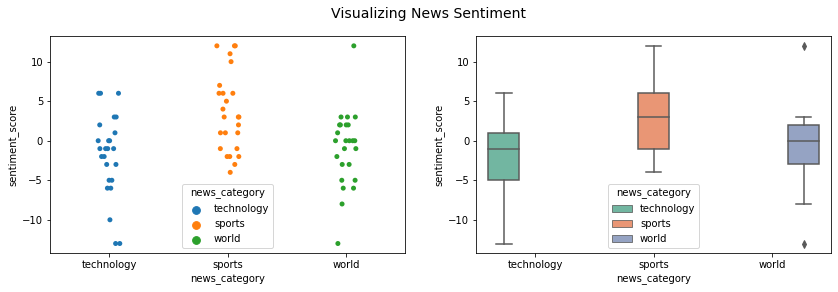

In [143]:

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
sp = sns.stripplot(x='news_category', y="sentiment_score", 
                   hue='news_category', data=df, ax=ax1)
bp = sns.boxplot(x='news_category', y="sentiment_score", 
                 hue='news_category', data=df, palette="Set2", ax=ax2)
t = f.suptitle('Visualizing News Sentiment', fontsize=14)

Nous pouvons voir que la propagation de la polarité des sentiments est beaucoup plus élevée dans le sport et le monde par rapport à la technologie où de nombreux articles semblent avoir une polarité négative. Nous pouvons également visualiser la fréquence des étiquettes de sentiment.

/home/ismail/.local/lib/python3.8/site-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


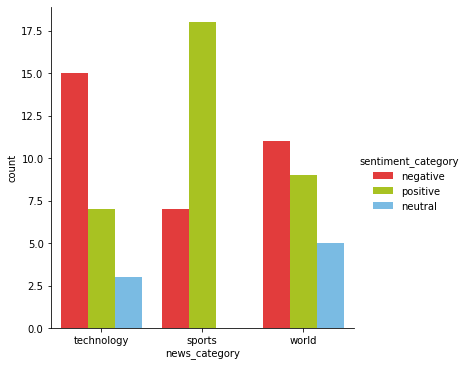

In [144]:

fc = sns.factorplot(x="news_category", hue="sentiment_category", 
                    data=df, kind="count", 
                    palette={"negative": "#FE2020", 
                             "positive": "#BADD07", 
                             "neutral": "#68BFF5"})

Pas de surprise ici que la technologie a le plus grand nombre d'articles négatifs et le monde le plus grand nombre d'articles positifs. Les sports peuvent avoir des articles plus neutres en raison de la présence d'articles de nature plus objective (parler d'événements sportifs sans la présence d'émotions ou de sentiments). Plongeons plus profondément dans les articles de presse sur les sentiments les plus positifs et les plus négatifs pour les nouvelles technologiques .

12.0

In [172]:
maxim = max(df[(df.news_category == 'technology')].sentiment_score)
minim = min(df[(df.news_category == 'technology')].sentiment_score)
pos_idx = df[(df.news_category=='technology') & (df.sentiment_score == maxim)].index[0]
neg_idx = df[(df.news_category=='technology') & (df.sentiment_score == minim)].index[0]

print('Most Negative Tech News Article:', news_df.iloc[neg_idx][['news_article']][0])

print('Most Positive Tech News Article:', news_df.iloc[pos_idx][['news_article']][0])

Most Negative Tech News Article: The UK has opened the first "smart" prison designed with latest technology and with no bars on windows, to drive down crime and reduce reoffending. Her Majesty's Prison (HMP) Five Wells' cells will be called "rooms" and inmates "residents". The 1,700-capacity prison has been designed with education, training and jobs for prisoners on release as its main purposes, government said.
Most Positive Tech News Article: Ukraine's President Volodymyr Zelenskyy on a video call with Elon Musk invited the world's richest man to visit Ukraine. "So, If you have time after the war, you are very welcome, I invite you," Zelenskyy told Musk. In a video clip shared by Zelenskyy on Instagram, Musk responded, "That sound's good, I look forward to visiting once things are..."


In [173]:
maxim = max(df[(df.news_category == 'world')].sentiment_score)
minim = min(df[(df.news_category == 'world')].sentiment_score)
pos_idx = df[(df.news_category=='world') & (df.sentiment_score == maxim)].index[0]
neg_idx = df[(df.news_category=='world') & (df.sentiment_score == minim)].index[0]

print('Most Negative WORLD News Article:', news_df.iloc[neg_idx][['news_article']][0])

print('Most Positive WORLD News Article:', news_df.iloc[pos_idx][['news_article']][0])

Most Negative WORLD News Article: Denis Kireev, a member of Ukraine's negotiating team during first round of peace talks with Russia, was found dead amid claims he was a spy. Ukraine's Ministry of Defence said the 45-year-old was killed during an operation to "defend the nation" but some Ukrainian MPs claimed he was killed by Ukraine's security service after resisting arrest on suspicion of treason.
Most Positive WORLD News Article: Ukrainian President Volodymyr Zelenskyy on Monday said he informed Indian PM Narendra Modi about "Ukraine countering Russian aggression" after reports said the two leaders spoke on the phone. "India appreciates the assistance to its citizens during the war and Ukraine's commitment to direct peaceful dialogue at the highest level. Grateful for the support to the Ukrainian people," said Zelenskyy.


In [ ]:
df[(df.news_category == 'world')].sentiment_score.value_counts(sort=True)

In [169]:
df.news_category.value_counts()

technology    25
sports        25
world         25
Name: news_category, dtype: int64

In [175]:
maxim = max(df[(df.news_category == 'sports')].sentiment_score)
minim = min(df[(df.news_category == 'sports')].sentiment_score)
pos_idx = df[(df.news_category=='sports') & (df.sentiment_score == maxim)].index[0]
neg_idx = df[(df.news_category=='sports') & (df.sentiment_score == minim)].index[0]

print('Most Negative sports News Article:', news_df.iloc[neg_idx][['news_article']][0])

print('Most Positive sports News Article:', news_df.iloc[pos_idx][['news_article']][0])

Most Negative sports News Article: Thai police are investigating after a German woman got into the back of the ambulance transporting the body of late Australian cricketer Shane Warne from Koh Samui island. The woman, carrying a bunch of flowers, was allowed to spend about 40 seconds alone in the van, raising questions about security. Warne's friends in Thailand reportedly couldn't identify the woman. 
Most Positive sports News Article: Fashion designer Masaba Gupta wished her father, former West Indies cricketer Vivian Richards on his 70th birthday and shared a throwback picture with him. Taking to Instagram, Masaba wrote, "My father is unrelenting [and] focussed...[He] has lived his life in the pursuit of greatness...I set out in my pursuit to be even half as great as you...Happy 70th birthday papa!"
